In [1]:
import os
import skimage.io
import matplotlib.pyplot as plt
import numpy as np

sign_path = './mathop/'
sign_names = [nm for nm in os.listdir(sign_path) if '.png' in nm]  # make sure to only load .png
sign_names.sort()  # sort file names
ic_sign = skimage.io.imread_collection([os.path.join(sign_path, nm) for nm in sign_names])
sign_img = skimage.io.concatenate_images(ic_sign)

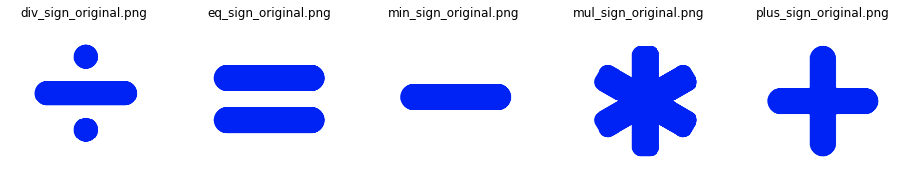

In [2]:
fig, axes = plt.subplots(1, sign_img.shape[0], figsize=(16, 4))
for ax, im, nm in zip(axes.ravel(), sign_img, sign_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)   

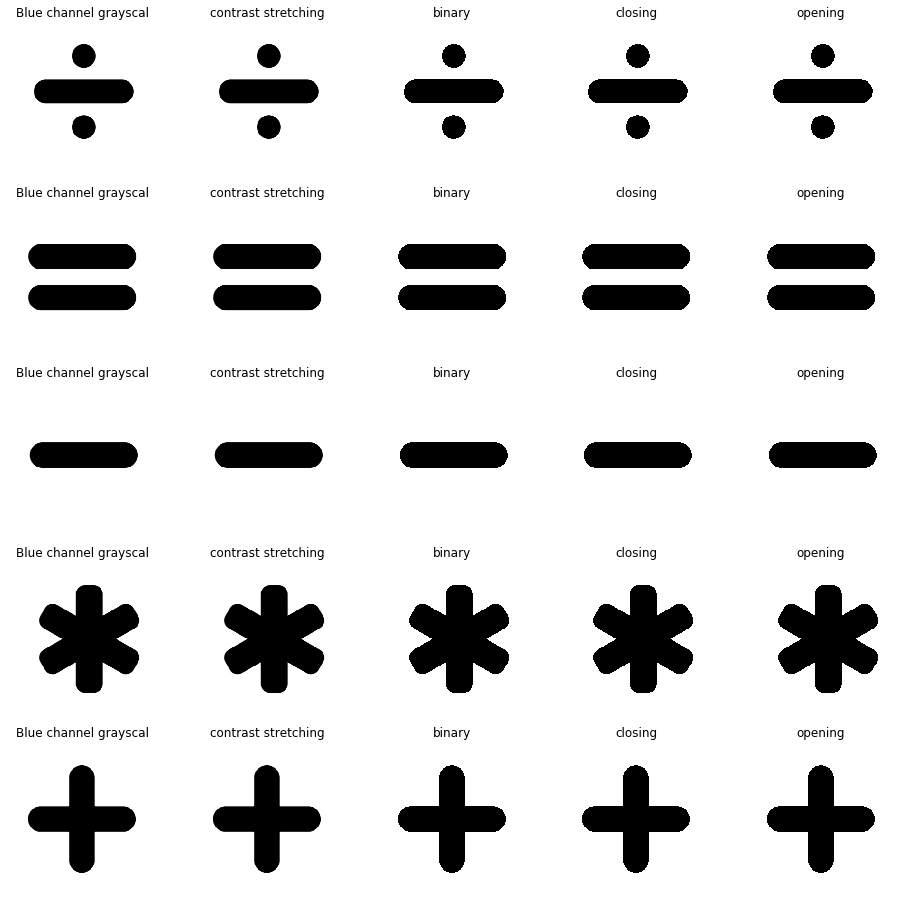

In [3]:
from skimage.filters import threshold_otsu
from skimage import morphology
from skimage import exposure

binary_signs = []

fig, ax = plt.subplots(5, 5, figsize=(16, 16))
for ind, im in zip(range(5), sign_img):
    
    img = skimage.color.rgb2gray(im)
    
    ax[ind,0].imshow(img, cmap='gray')
    ax[ind,0].set_title('Blue channel grayscal')
    ax[ind,0].axis('off')
    
    a, b = np.percentile(img, (0.8, 70))
    res = exposure.rescale_intensity(img, in_range=(a, b))
        
    ax[ind,1].imshow(res, cmap='gray')
    ax[ind,1].set_title('contrast stretching')
    ax[ind,1].axis('off')
    
    # Applying multi-Otsu threshold for the default value, generating
    # three classes.
    threshold = threshold_otsu(img)

    binary = img > threshold
    
    ax[ind,2].imshow(binary, cmap='gray')
    ax[ind,2].set_title('binary')
    ax[ind,2].axis('off')
    
    openin = morphology.binary_opening(binary, skimage.morphology.selem.disk(1))
    
    ax[ind,3].imshow(openin, cmap='gray')
    ax[ind,3].set_title('closing')
    ax[ind,3].axis('off')
    
    close = morphology.binary_closing(binary, skimage.morphology.selem.disk(1))
    
    ax[ind,4].imshow(close, cmap='gray')
    ax[ind,4].set_title('opening')
    ax[ind,4].axis('off')
    
    binary_signs.append(binary)

plt.show()

In [93]:
from skimage.transform import rotate

def generate_sign_dataset(sign_img, nb):
    
    gray_signs = [skimage.color.rgb2gray(im) for im in sign_img]
    
    dataset = []
    labels = []
    for k in range(nb):
        ind = np.random.randint(len(gray_signs))
        dataset.append(rotate(gray_signs[ind], np.random.randint(360), cval=1))
        labels.append(ind)
    return np.array(dataset), np.array(labels)
                              
dataset_sign, labels = generate_sign_dataset(sign_img, 125)
print(dataset_sign[0].shape)

(316, 316)


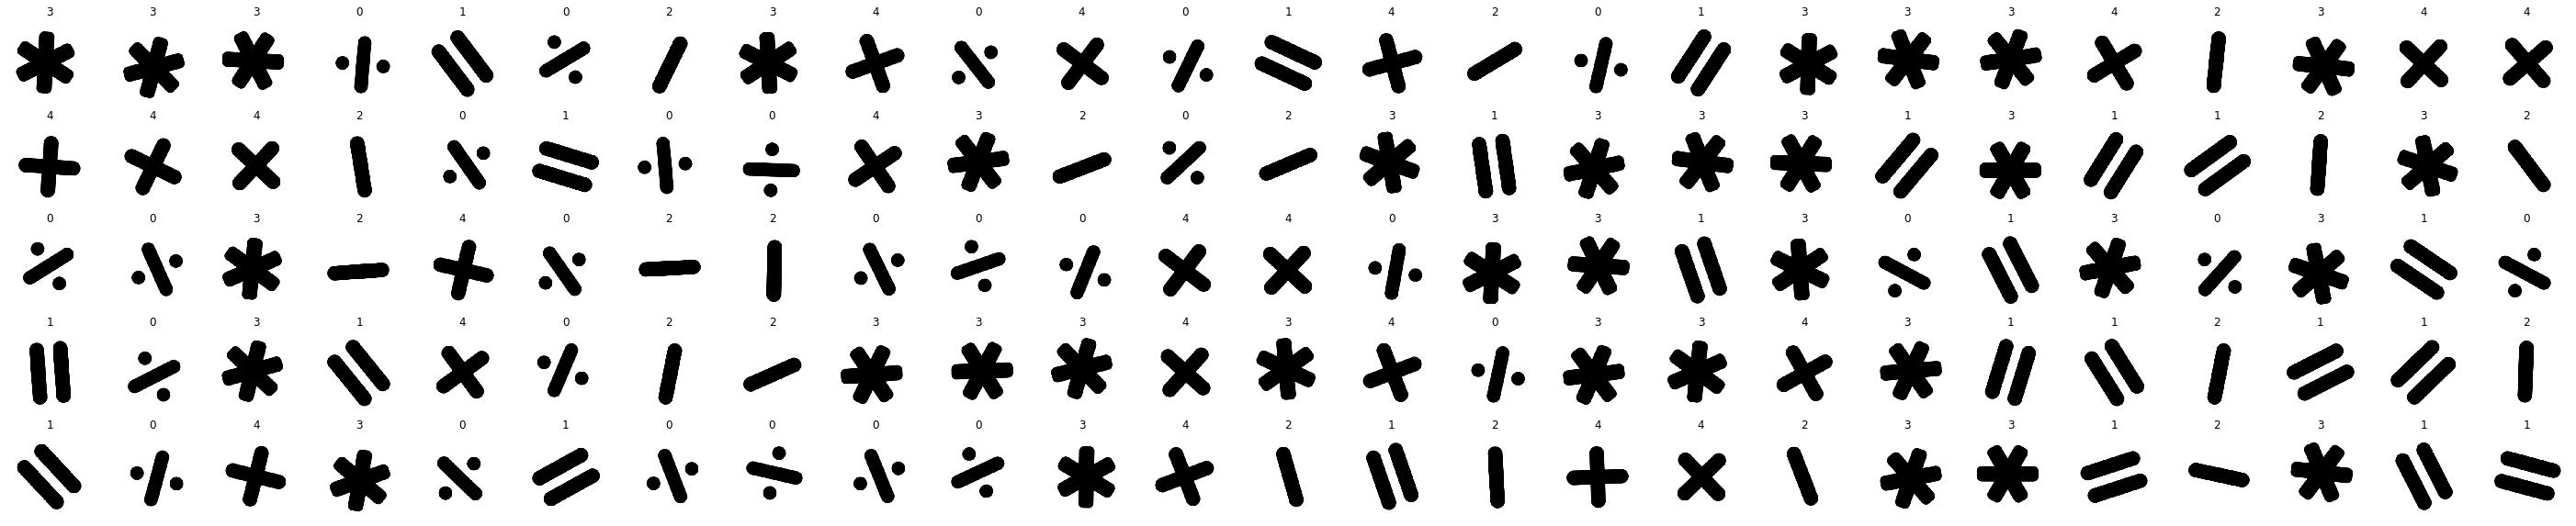

In [94]:
fig, axes = plt.subplots(5, 25, figsize=(50, 10))
for ax, img, nm in zip(axes.ravel(), dataset_sign, labels):
    ax.imshow(img, cmap='gray')
    ax.set_title(str(nm))
    ax.axis('off')
plt.show()

<b>###############################################################################################################################################################################################################</b> <br>
MLP with scikit image

In [108]:
from sklearn.neural_network import MLPClassifier

train_input, train_target = generate_sign_dataset(sign_img, 1000)
test_input, test_target = generate_sign_dataset(sign_img, 1000)


train_input = (train_input/255.).astype(int)
test_input = (test_input/255.).astype(int)

train_input = train_input.reshape(train_input.shape[0],-1)
test_input = test_input.reshape(test_input.shape[0],-1)

#model MLP : hidden layer = (100,), activation = Relu, optimzer = SGD, alpha is the penalty term, loss = cross entropy
mlp = MLPClassifier(solver='sgd', alpha=5e-3, batch_size=100, verbose=10, random_state=1, max_iter=50, learning_rate_init=5e-2)

# this line fits the model with the training data
mlp.fit(train_input, train_target)

# Check accuracy for training set and test set
print("Training set score: %f" % mlp.score(train_input, train_target))
print("Test set score: %f" % mlp.score(test_input, test_target))

Iteration 1, loss = 1.62036511
Iteration 2, loss = 1.61486017
Iteration 3, loss = 1.61439174
Iteration 4, loss = 1.61492850
Iteration 5, loss = 1.61492610
Iteration 6, loss = 1.61445312
Iteration 7, loss = 1.61471967
Iteration 8, loss = 1.61447362
Iteration 9, loss = 1.61487551
Iteration 10, loss = 1.61444043
Iteration 11, loss = 1.61570165
Iteration 12, loss = 1.61457512
Iteration 13, loss = 1.61530033
Iteration 14, loss = 1.61497218
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training set score: 0.215000
Test set score: 0.215000


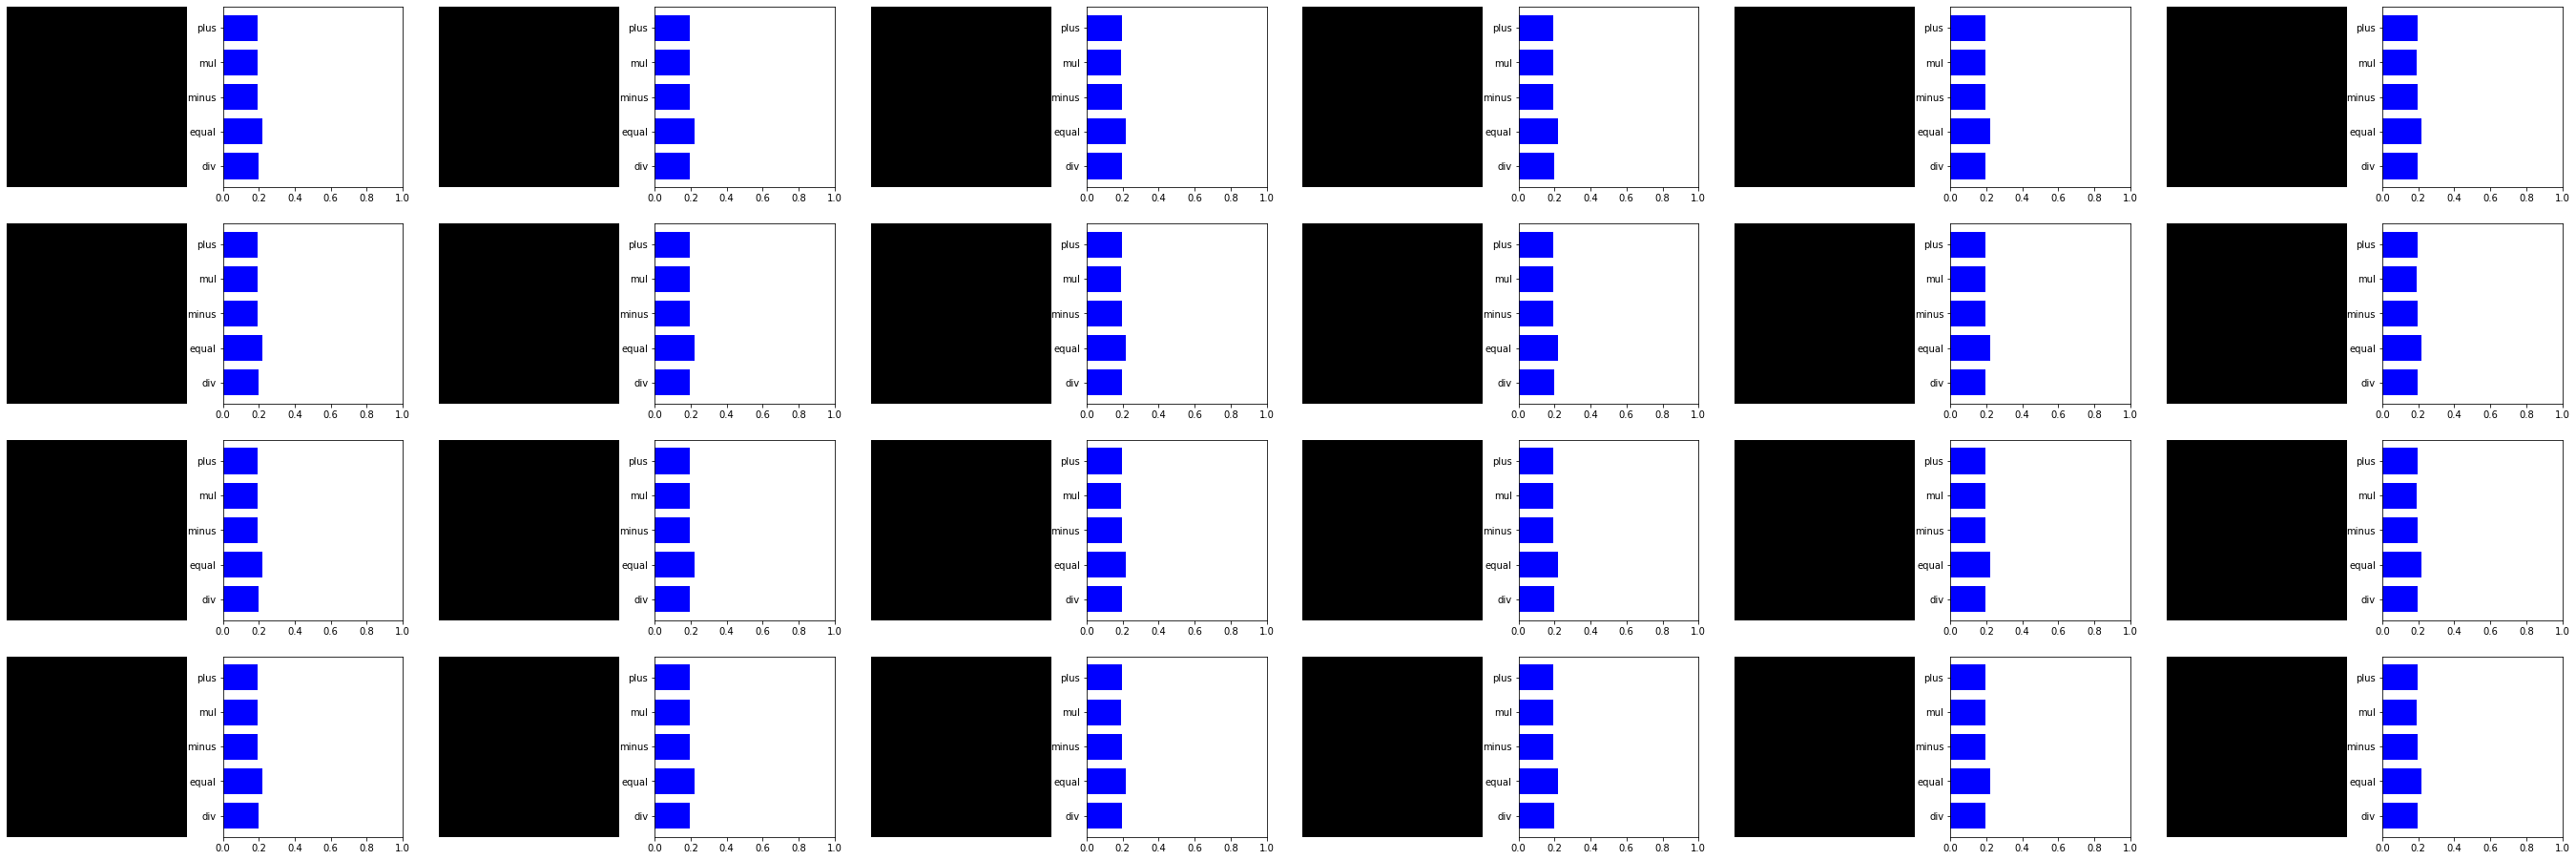

In [109]:
np.random.seed(0)
a = np.random.randint(1000, size=(24))
y = mlp.predict_proba(test_input[a].reshape(24,-1))

fig, axes = plt.subplots(4, 12, figsize=(48,16))
ax = axes.ravel()

for ind in range(y.shape[0]):
    
    ax[2*ind].imshow(test_input[a[ind]].reshape(316,316), cmap='gray')
    ax[2*ind].axis('off')
    
    width = 0.75
    xpos = np.arange(y.shape[1])  # the x locations for the groups
    ax[2*ind+1].barh(xpos, y[ind], width, color="blue")
    ax[2*ind+1].set_yticks(xpos)
    ax[2*ind+1].set_yticklabels(['div','equal','minus','mul','plus'])
    ax[2*ind+1].set_xlim(0,1)

plt.show()

[[0.00392157 0.00392157 0.00392157 ... 0.00392157 0.00392157 0.00392157]]


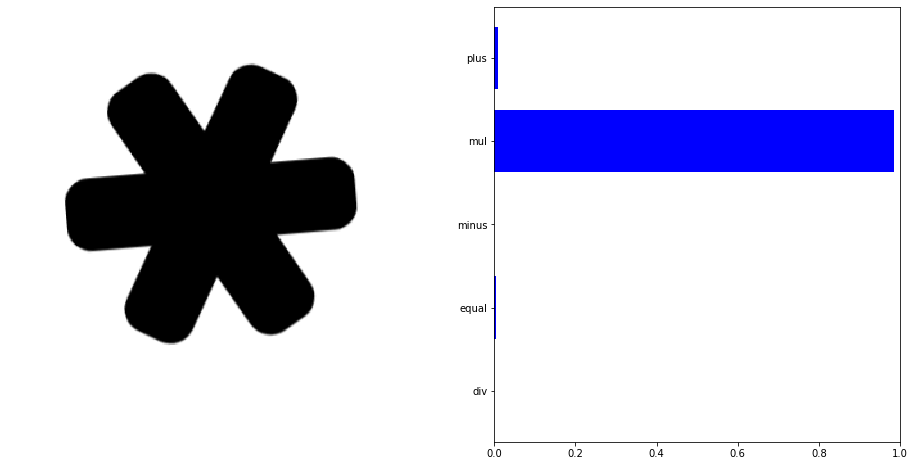

In [9]:
from skimage.transform import resize

image_resized = test_input[316]

y = mlp.predict_proba(image_resized.reshape(1,-1))
print(image_resized.reshape(1,-1))


fig, axes = plt.subplots(1, 2, figsize=(16,8))
ax = axes.ravel()
    
ax[0].imshow(image_resized.reshape(316,316), cmap='gray')
ax[0].axis('off')

width = 0.75
xpos = np.arange(y[0].shape[0])  # the x locations for the groups
ax[1].barh(xpos, y[0], width, color="blue")
ax[1].set_yticks(xpos)
ax[1].set_yticklabels(['div','equal','minus','mul','plus'])
ax[1].set_xlim(0,1)

plt.show()

<b>###############################################################################################################################################################################################################</b> <br>
TEST

> Extracting images from video
done


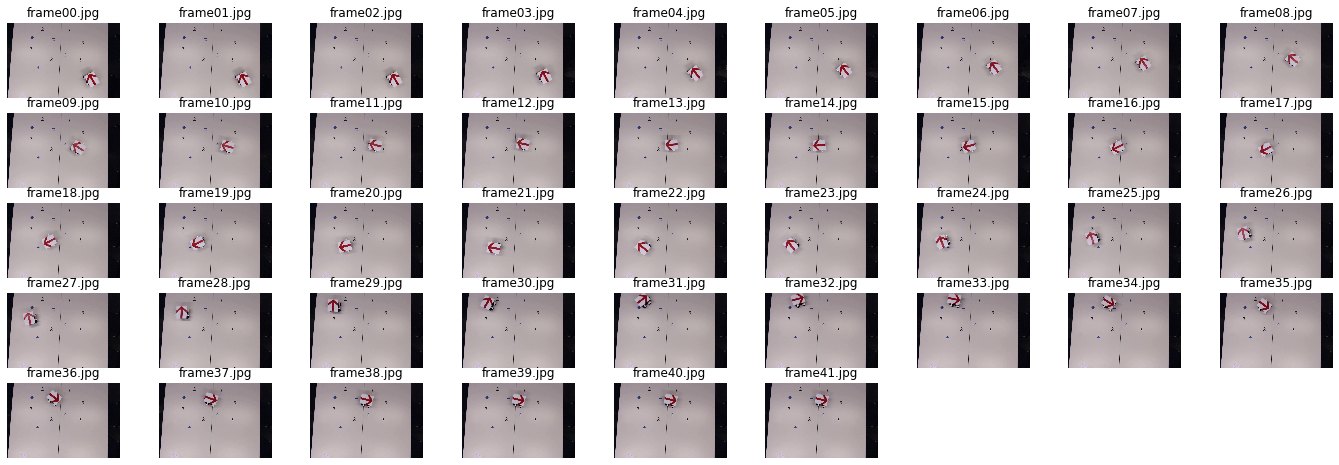

In [10]:
%matplotlib inline
from helpers import extract_images, load_data
import matplotlib.pyplot as plt
import numpy as np

# extract images from video
extract_images(data_path='./data/robot_parcours_1.avi')

# load data from extracted images
images, images_names = load_data()

# plot images
fig, axes = plt.subplots(5, int(len(images)/5)+1, figsize=(24, 8))
for ax, im, nm in zip(axes.ravel(), images, images_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)   
for ax in axes.ravel()[len(images):]:
    fig.delaxes(ax)

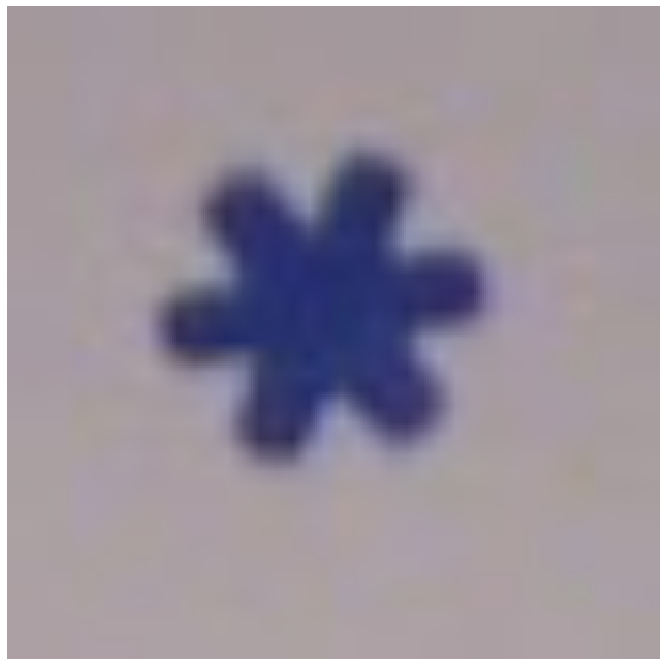

In [73]:
test_im = images[0]

fig, ax = plt.subplots(1, 1, figsize=(18,12))
block = test_im[75:115, 140:180]
block = resize(block, (316,316,3), anti_aliasing=True)
ax.imshow(block)
ax.axis('off')
ind += 1
plt.show()

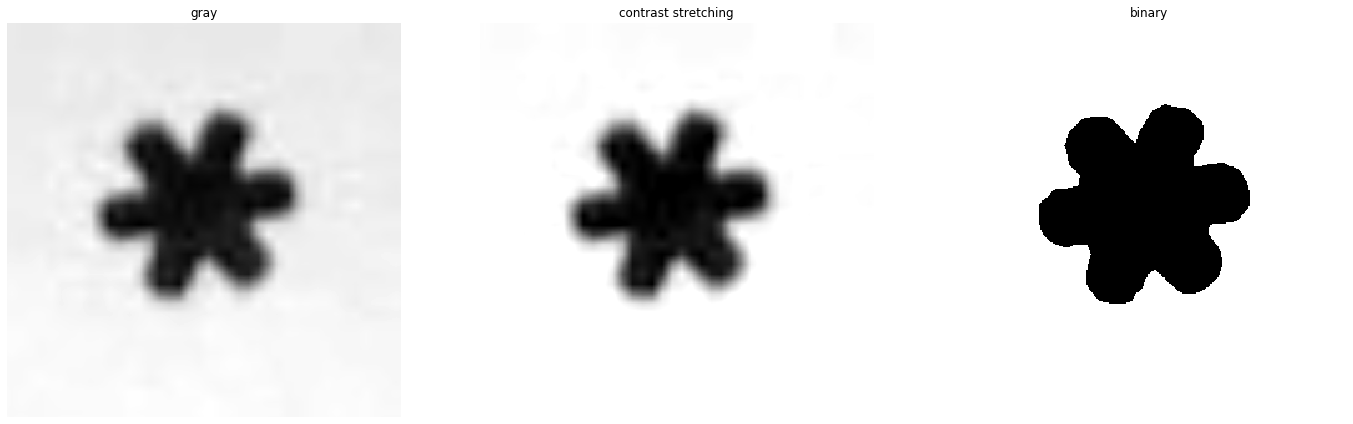

In [85]:
from skimage import exposure
from skimage.filters import threshold_otsu

fig, ax = plt.subplots(1,3, figsize=(24, 16))
    
img = skimage.color.rgb2gray(block)

ax[0].imshow(img, cmap='gray')
ax[0].set_title('gray')
ax[0].axis('off')
   
a, b = np.percentile(img, (0.8, 40))
res = exposure.rescale_intensity(img, in_range=(a, b))
    
ax[1].imshow(res, cmap='gray')
ax[1].set_title('contrast stretching')
ax[1].axis('off')

threshold = threshold_otsu(res)

binary = (img > threshold)

ax[2].imshow(binary, cmap='gray')
ax[2].set_title('binary')
ax[2].axis('off')

plt.show()

In [102]:
print(binary[180,:].astype(float))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


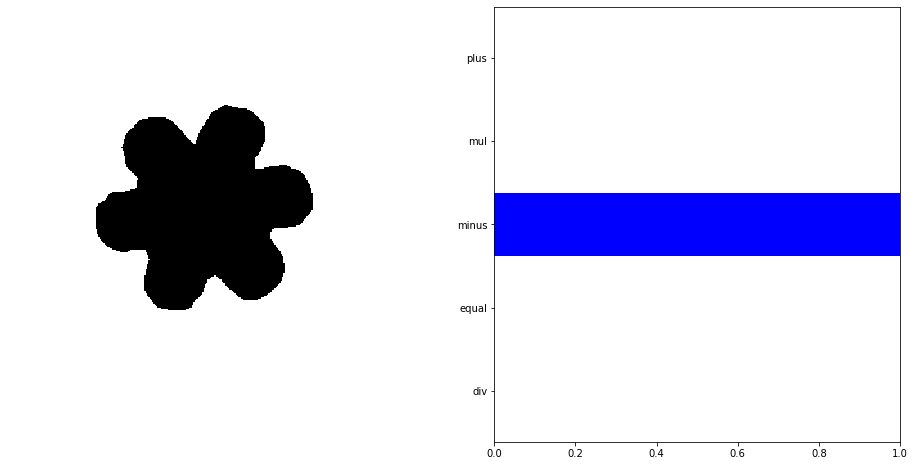

In [100]:
from skimage.transform import resize

image_resized = binary.astype(float)

y = mlp.predict_proba(image_resized.reshape(1,-1))

fig, axes = plt.subplots(1, 2, figsize=(16,8))
ax = axes.ravel()
    
ax[0].imshow(image_resized, cmap='gray')
ax[0].axis('off')

width = 0.75
xpos = np.arange(y[0].shape[0])  # the x locations for the groups
ax[1].barh(xpos, y[0], width, color="blue")
ax[1].set_yticks(xpos)
ax[1].set_yticklabels(['div','equal','minus','mul','plus'])
ax[1].set_xlim(0,1)

plt.show()

In [101]:
print(y[0])

[0. 0. 1. 0. 0.]


In [89]:
a, b = generate_sign_dataset(sign_img, 2)

In [104]:
print(a[1][180,:].astype(int))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [91]:
test_input[0].shape

(99856,)

In [92]:
image_resized.reshape(-1).shape

(99856,)